### DATA 620
### Assignment 10/11: Document Classification
Keith Folsom
11/12/2017

#### Assignment Overview

It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  http://archive.ics.uci.edu/ml/datasets/Spambase

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

#### For this assignment, we'll be creating a spam detection classifier to predict whether email messages are spam or ham using a different set of tagged documents.  The spam and ham corpora can be found here:

http://spamassassin.apache.org/old/publiccorpus/

The following code assumes that the following files have been unzipped and untarred to a local directory:
* 20021010_hard_ham.tar.bz2   (ham emails - more difficulat to categorize)  
* 20021010_spam.tar.bz2      (spam emails)  
* 20030228_hard_ham.tar.bz2 (ham emails - used as a test for the selected classifier) 
* 20030228_spam.tar.bz2

The local directories should have the following structure within the current working directory, with all email files in the lowest subdirectory:

* ./20021010_hard_ham/hard_ham
* ./20030228_hard_ham/hard_ham
* ./spam  
* ./20030228_spam/spam/

### The general approach to creating the spam detection classifier will be:

1. Load the spam and ham email messages
2. Apply preprocessing & extract features
4. Train the classifier
5. Evaluate the classifier
6. Classifer selection and prediction againts ham emails



### Import Necessary Packages

In [1]:
import nltk
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import NaiveBayesClassifier, classify
from nltk import DecisionTreeClassifier, classify
from nltk import MaxentClassifier, classify
from collections import Counter

import numpy  
import pandas as pd
import random
import string
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC


### Step 1 - Load Ham and Spam Email Messages as Corpora





In [2]:
# create a function to process the files in a given directory and
# return three outputs used throughout the analysis
    # 1. nltk.corpus.reader.plaintext.PlaintextCorpusReader
    # 2. nltk.text.Text
    # 3. list of emails tagged as either ham or spam

def init_corpus(dir, tag):
    
    # need to use latin-1 encoding to avoid issues with special characters
    # use PlaintextCorpusReader to read all the files in the ham corpus directory set above
    corpus0 = PlaintextCorpusReader(dir, '.*', encoding='latin-1') 
    
    # extract the sentences from the orpus
    # note that the sentences are tokenized as a result
    corpus  = nltk.Text(corpus0.sents())
    
    # tag as spam for later usage
    emails = [(email, tag) for email in corpus]
    
    return corpus0, corpus, emails

In [3]:
## Ham Email Messages 
## Initialize using a set of hard ham email messages 
## These have been deemed more difficult to classify
## ===================================================
hamcorpusdir = './20021010_hard_ham/hard_ham'   # local directory structure of the ham emails

hamcorpus0, hamcorpus, ham_emails = init_corpus(hamcorpusdir, 'ham')

In [4]:
## Spam Email Messages 
## Initialize using a set of spam email messages 
## ===================================================
spamcorpusdir = './spam' # Local directory of the spam email messages.

spamcorpus0, spamcorpus, spam_emails = init_corpus(spamcorpusdir, 'spam')

#### Generate some topline statistics about the corpora.

In [5]:
def corpus_stats(corpus, name):

    total_files = len(corpus.fileids())
    total_chars = len(corpus.raw())
    total_words = len(corpus.words())
    total_sentences = len(corpus.sents())

    print("{} Corpus: ".format(name))
    print("===========================")
    print("Total Files = {}".format(total_files))    
    print("Total Words = {}".format(total_words))
    print("Avg Words Per File = {}".format(total_words/total_files))
    print("Total Sentences = {}".format(total_sentences))
    print("Avg Sentences Per File = {}".format(total_sentences/total_files))

In [6]:
corpus_stats(spamcorpus0, "Spam Corpus")

Spam Corpus Corpus: 
Total Files = 501
Total Words = 769207
Avg Words Per File = 1535
Total Sentences = 12107
Avg Sentences Per File = 24


In [7]:
corpus_stats(hamcorpus0, "Ham Corpus")

Ham Corpus Corpus: 
Total Files = 250
Total Words = 1513630
Avg Words Per File = 6054
Total Sentences = 24035
Avg Sentences Per File = 96


#### Combine the spam and ham emails together and shuffle them randomly
Set a random seed value to make the results reproducible

In [8]:
# combine
random_seed=1534678
random.seed(random_seed)

# combine the spam and ham emails together
all_emails = spam_emails + ham_emails

In [9]:
# shuffle the combined emails
random.shuffle(all_emails)

### Step 2 - Preprocessing & Feature Extraction
Preprocessing the data will focus on trying to normalize the data so that variations of same word are collapsed into a single version.  We'll use a few prepocessing approaches such as lemmatization, stemming, and removing stopwords and punctuation.

In [10]:
#stoplist = stopwords.words("english")

# Using a lemmatizer and convert to lowercase
def preprocess1(sentence):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(word.lower()) for word in sentence]

# Using stemming
def preprocess2(sentence):   
    porter = nltk.PorterStemmer()  
    return [porter.stem(word.lower()) for word in sentence]

def preprocess3(sentence):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in sentence if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

### Features Extraction

We'll look at three methods to create featuresets for the classification modeling training step.  The evaluation phase will determine which of the three yields the best results.


In [14]:
stoplist = stopwords.words("english")
## get_features function to extract features
def get_features(text, preprocessor):
    
    """
    Accepts in a string of text and the preprocessing function to be applied
    """
    return {word: True for word in preprocessor(text) if not word in stoplist}

In [15]:
# extract features using the first preprocessor which is using lemmatization
all_features1 = [(get_features(email, preprocess1), label) for (email, label) in all_emails]

In [16]:
# extract features using the second preprocessor which is using stemming
all_features2 = [(get_features(email, preprocess2), label) for (email, label) in all_emails]

In [17]:
# extract features using the third preprocessor which essentially returns cleaned text
all_features3 = [(get_features(email, preprocess3), label) for (email, label) in all_emails]

### Step 3 - Train the Classifiers
In this step, we're going to evaluate three varieties of classifiers, each using a different preprocessing step to extract different featuresets.

1. NaiveBayes
2. Logistic Regression
3. Linear SVC  

In [18]:
## NaiveBayes 
def train_NB(features, samples_proportion):
    train_size = int(len(features) * samples_proportion)
    train_set, test_set = features[:train_size], features[train_size:]
    
    print ('Training set size = ' + str(len(train_set)) + ' emails')
    print ('Test set size = ' + str(len(test_set)) + ' emails')
    
    classifier = NaiveBayesClassifier.train(train_set)
    return train_set, test_set, classifier

## Logistic Regression
def train_LR(features, samples_proportion):
    train_size = int(len(features) * samples_proportion)
    train_set, test_set = features[:train_size], features[train_size:]
    print ('Training set size = ' + str(len(train_set)) + ' emails')
    print ('Test set size = ' + str(len(test_set)) + ' emails')
    
    LogisticRegression_classifier = SklearnClassifier(LogisticRegression())   
    classifier = LogisticRegression_classifier.train(train_set)
    
    return train_set, test_set, classifier

## LinearSVC
def train_LSVC(features, samples_proportion):
    train_size = int(len(features) * samples_proportion)
    train_set, test_set = features[:train_size], features[train_size:]
    print ('Training set size = ' + str(len(train_set)) + ' emails')
    print ('Test set size = ' + str(len(test_set)) + ' emails')
    
    LinearSVC_classifier = SklearnClassifier(LinearSVC())
    classifier = LinearSVC_classifier.train(train_set)
    
    return train_set, test_set, classifier


### Train the NaiveBayes Classifiers

In [19]:
train_set1_NB, test_set1_NB, classifier1_NB = train_NB(all_features1, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [20]:
train_set2_NB, test_set2_NB, classifier2_NB = train_NB(all_features2, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [21]:
train_set3_NB, test_set3_NB, classifier3_NB = train_NB(all_features3, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


### Train the Logistic Regression Classifiers

In [22]:
train_set1_LR, test_set1_LR, classifier1_LR = train_LR(all_features1, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [23]:
train_set2_LR, test_set2_LR, classifier2_LR = train_LR(all_features2, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [24]:
train_set3_LR, test_set3_LR, classifier3_LR = train_LR(all_features3, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


### Train the Linear SVC Classifiers

In [25]:
train_set1_LSVC, test_set1_LSVC, classifier1_LSVC = train_LSVC(all_features1, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [26]:
train_set2_LSVC, test_set2_LSVC, classifier2_LSVC = train_LSVC(all_features2, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


In [27]:
train_set3_LSVC, test_set3_LSVC, classifier3_LSVC = train_LSVC(all_features3, 0.8)

Training set size = 28913 emails
Test set size = 7229 emails


### Step 4 - Evaluate the Classifiers

In [28]:
# Code here for the confusion is heavily borrowed from our 620 group project
def plot_confusion_matrix(cm, classes,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. 
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if False else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    return

In [29]:
def evaluate_classifier(train_set, test_set, classifier, preprocessor):
    print("Classifier Performance Evaluation")
    print("===================================\n")
    
    print('Accuracy on the training set = ' + str(classify.accuracy(classifier, train_set)))
    print('Accuracy of the test set = ' + str(classify.accuracy(classifier, test_set)))
    
    ## TRAIN ##
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(get_features(email, preprocessor)) for (email, label) in train_set]
    
    # extract actual classes (gold)
    train_set_gold = [tag for (n, tag) in train_set]
    
    # create confusion matrix
    train_confusion_matrix=confusion_matrix(train_set_gold, train_set_predictions)
    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions, digits=4)
    
    # display performance report (train)
    print('\nModel Performance Metrics (Train):')
    print(train_report)
    
    #----------------------------------------------------------------------------------
    ## TEST ##
    # create predicted classes (test)
    test_set_predictions = [classifier.classify(get_features(email, preprocessor)) for (email, label) in test_set]
    
    # extract actual classes (gold)
    test_set_gold = [tag for (n, tag) in test_set]
    
    # create confusion matrix
    test_confusion_matrix=confusion_matrix(test_set_gold, test_set_predictions)
           
    # create table with precision, recall, f1-score, and support
    test_report=classification_report(test_set_gold, test_set_predictions, digits=4)
    
    # display performance report (train)
    print('\nModel Performance Metrics (Test):')
    print(test_report)
    
    ## Confusion Matrices - Test vs. Train side-by-side
    # size figure
    plt.figure(figsize=(10,6))
    # add first subplot
    plt.subplot(2, 2, 1)
    # plot confusion matrix
    plot_confusion_matrix(train_confusion_matrix, classes=['spam','ham'], title="Confusion Matrix - Training Set")
    # add second subplot
    plt.subplot(2, 2, 2)
    # plot confusion matrix (test)
    plot_confusion_matrix(test_confusion_matrix, classes=['spam','ham'], title="Confusion Matrix - Test Set")
    
    return 

### NaiveBayes Evaluation

Classifier Performance Evaluation

Accuracy on the training set = 0.904921661536
Accuracy of the test set = 0.872181491216

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9346    0.9218    0.9282     19263
       spam     0.8481    0.8713    0.8595      9650

avg / total     0.9057    0.9050    0.9053     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9104    0.8946    0.9024      4772
       spam     0.8020    0.8291    0.8153      2457

avg / total     0.8736    0.8723    0.8728      7229



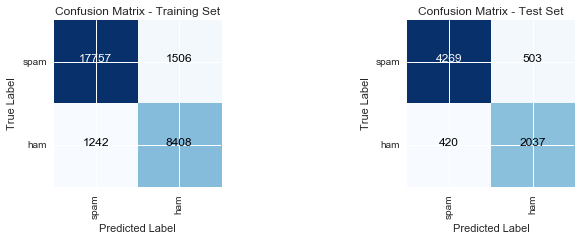

In [30]:
# preprocessing of features based on lemmatization
evaluate_classifier(train_set1_NB, test_set1_NB, classifier1_NB, preprocess1)

Classifier Performance Evaluation

Accuracy on the training set = 0.893196831875
Accuracy of the test set = 0.865818232121

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9276    0.9070    0.9172     19263
       spam     0.8222    0.8587    0.8400      9650

avg / total     0.8924    0.8908    0.8914     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9060    0.8843    0.8950      4772
       spam     0.7853    0.8217    0.8031      2457

avg / total     0.8650    0.8631    0.8638      7229



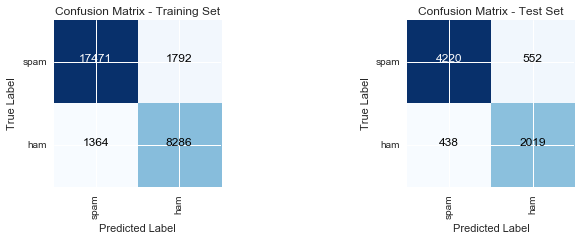

In [31]:
# preprocessing of features based on stemming
evaluate_classifier(train_set2_NB, test_set2_NB, classifier2_NB, preprocess2)

Classifier Performance Evaluation

Accuracy on the training set = 0.989174419811
Accuracy of the test set = 0.823488725965

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9857    0.9982    0.9919     19263
       spam     0.9964    0.9711    0.9836      9650

avg / total     0.9893    0.9892    0.9891     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.7905    0.9969    0.8817      4772
       spam     0.9876    0.4868    0.6521      2457

avg / total     0.8575    0.8235    0.8037      7229



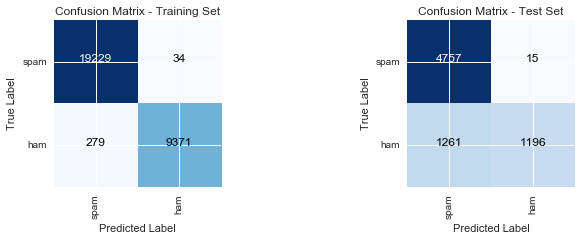

In [32]:
# preprocessing of features based on cleaned Text -- removal of punctuation, stopwords.  
evaluate_classifier(train_set3_NB, test_set3_NB, classifier3_NB, preprocess3)

__Note__ The featureset based on the the third preprocessing option appear to be overfitting the training dataset.  The peformance metrics against the test dataset show some marked degradation.  Consequently, we'll discontinue using this in subsequent classifiers.

### Logistic Regression Evaluation

Classifier Performance Evaluation

Accuracy on the training set = 0.95925708159
Accuracy of the test set = 0.913819338774

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9600    0.9796    0.9697     19263
       spam     0.9575    0.9184    0.9376      9650

avg / total     0.9592    0.9592    0.9590     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9249    0.9466    0.9356      4772
       spam     0.8913    0.8506    0.8705      2457

avg / total     0.9134    0.9140    0.9135      7229



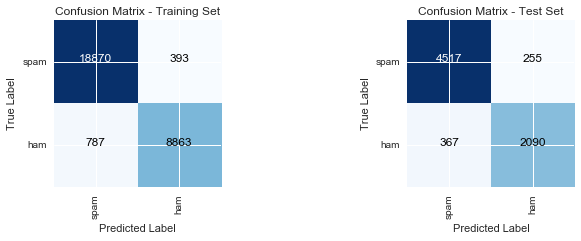

In [33]:
# preprocessing of features based on lemmatization
evaluate_classifier(train_set1_LR, test_set1_LR, classifier1_LR, preprocess1)

Classifier Performance Evaluation

Accuracy on the training set = 0.953135267873
Accuracy of the test set = 0.911744362982

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9518    0.9740    0.9628     19263
       spam     0.9455    0.9016    0.9230      9650

avg / total     0.9497    0.9498    0.9495     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9214    0.9436    0.9324      4772
       spam     0.8851    0.8437    0.8639      2457

avg / total     0.9091    0.9097    0.9091      7229



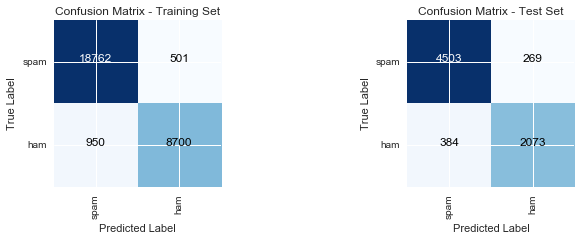

In [34]:
# preprocessing of features based on stemming
evaluate_classifier(train_set2_LR, test_set2_LR, classifier2_LR, preprocess2)

### Linear SVC Evaluation

Classifier Performance Evaluation

Accuracy on the training set = 0.97859094525
Accuracy of the test set = 0.917139300041

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9799    0.9874    0.9836     19263
       spam     0.9745    0.9595    0.9669      9650

avg / total     0.9781    0.9781    0.9781     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9377    0.9361    0.9369      4772
       spam     0.8763    0.8791    0.8777      2457

avg / total     0.9168    0.9167    0.9168      7229



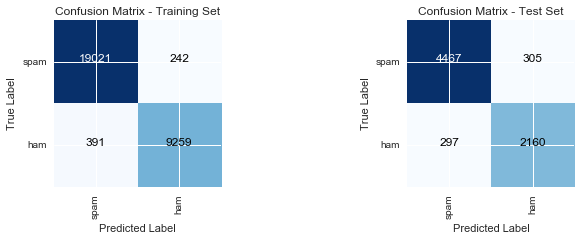

In [35]:
# preprocessing of features based on lemmatization
evaluate_classifier(train_set1_LSVC, test_set1_LSVC, classifier1_LSVC, preprocess1)

Classifier Performance Evaluation

Accuracy on the training set = 0.972987929305
Accuracy of the test set = 0.913542675335

Model Performance Metrics (Train):
             precision    recall  f1-score   support

        ham     0.9702    0.9842    0.9771     19263
       spam     0.9675    0.9397    0.9534      9650

avg / total     0.9693    0.9693    0.9692     28913


Model Performance Metrics (Test):
             precision    recall  f1-score   support

        ham     0.9313    0.9348    0.9331      4772
       spam     0.8725    0.8661    0.8693      2457

avg / total     0.9113    0.9115    0.9114      7229



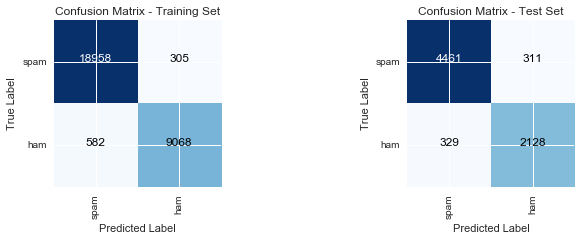

In [36]:
# preprocessing of features based on stemming
evaluate_classifier(train_set2_LSVC, test_set2_LSVC, classifier2_LSVC, preprocess2)

## Conclusion

Based on the three classifier evaluations above, the LinearSVC classifer using lemmatization preprocessing to select the featureset has the edge in peformance over the other classifiers.  Comparisons were made using the f1-score of the test dataset as compared to the other classification results.  

Let's see how the classifier does specifically on email messages which were categorized as ham, but were considered more difficult to categorize.  This should test the classifier to see if it incorrectly tags ham as spam email.

In [37]:
## Ham Email Messages 
## ========================

hardhamcorpusdir = './20030228_hard_ham/hard_ham/'   # local directory structure of the ham emails
hardhamcorpus0, hardhamcorpus, hard_ham_emails = init_corpus(hardhamcorpusdir, 'ham')

In [38]:
predictions = [classifier2_LSVC.classify(get_features(email, preprocess1)) for (email, label) in hard_ham_emails]

In [39]:
Counter(predictions), len(predictions)

(Counter({'ham': 21375, 'spam': 1660}), 23035)

__Of the ham messages (and in this case a new set of more difficult ham was used), the classifer accurately tagged 92.7% as ham.  Based on these results, using the LinearSVC classifer for classifiying ham would be a good choice.__

__How does it peform against spam?__

Let's check against known spam as second commparison

In [40]:
## Spam Email Messages 
## ========================

spam2corpusdir = './20030228_spam/spam/'   # local directory structure of the ham emails
spam2corpus0, spam2corpus, spam2_emails = init_corpus(spam2corpusdir, 'spam')

In [41]:
predictions = [classifier2_LSVC.classify(get_features(email, preprocess1)) for (email, label) in spam2_emails]

In [42]:
Counter(predictions), len(predictions)

(Counter({'ham': 2389, 'spam': 9637}), 12026)

__Of the spam messages, the classifer accurately tagged 80% as spam.  Based on these results, we would need to tune the model as a next step, particularly for spam.__